In [1]:
import shutil

# Copy entire dataset to writeable location
src = "/kaggle/input/corrrected-test-data/test"
dst = "/kaggle/working/corrected-test-warpd/test"

shutil.copytree(src, dst, dirs_exist_ok=True)
print("✅ Copied dataset to working directory.")


✅ Copied dataset to working directory.


In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

Starting RT-DETR Grad-CAM Analysis...
Loaded image: (1920, 1080)

ATTEMPTING GRAD-CAM
Registering hooks on layers:
Target score: 0.6088101267814636
✗ Grad-CAM failed - low quality result

FEATURE MAP VISUALIZATION
Processed feature map from model.0.stem2a.conv: 0.000 to 1.000
Processed feature map from model.7.m.5.conv1.conv: 0.000 to 1.000
Processed feature map from model.28.input_proj.1.0: 0.000 to 1.000

Using feature map visualization


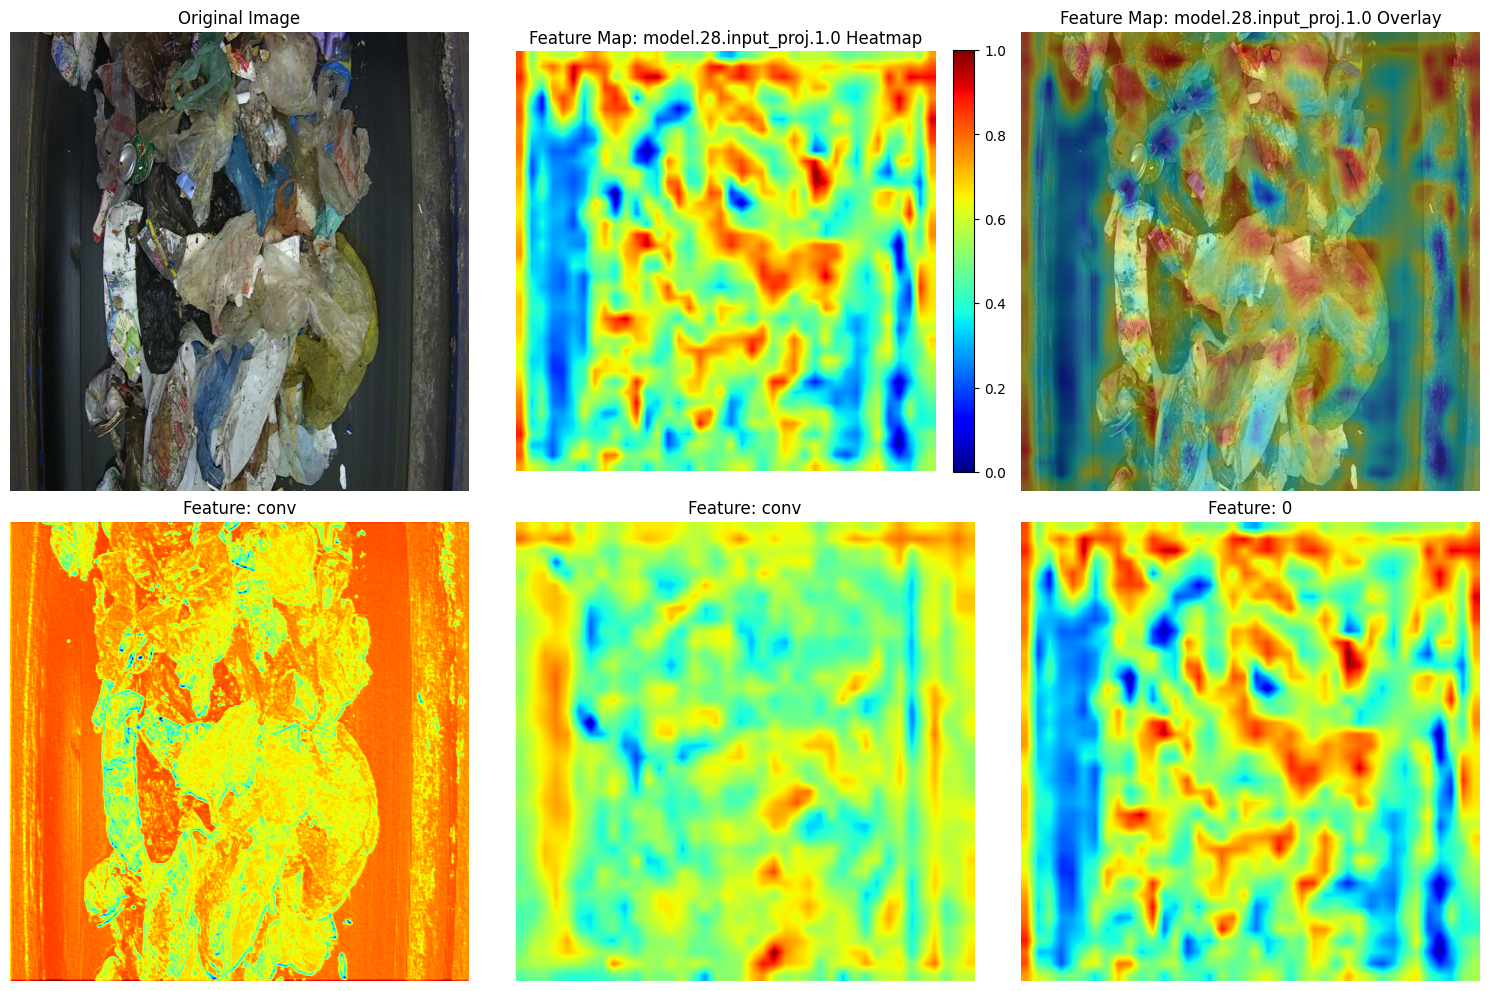


ANALYSIS COMPLETE
Final visualization method: Feature Map: model.28.input_proj.1.0
Activation range: 0.0000 to 1.0000
High activation pixels (>0.7): 61182
Medium activation pixels (>0.5): 240695
✓ Good activation regions detected!


In [3]:
import torch
import torch.nn.functional as F
from ultralytics import RTDETR
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image

class RTDETRGradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = {}
        self.gradients = {}
        self.hooks = []
        
    def register_hooks(self):
        """Register hooks on multiple layers to capture features"""
        def get_activation(name):
            def hook(model, input, output):
                self.feature_maps[name] = output.detach()
            return hook
        
        def get_gradient(name):
            def hook(model, input, output):
                def backward_hook(grad):
                    self.gradients[name] = grad.detach()
                if output.requires_grad:
                    handle = output.register_hook(backward_hook)
                    self.hooks.append(handle)
            return hook
        
        # Register hooks on backbone layers
        layers_to_hook = []
        for name, module in self.model.named_modules():
            if any(x in name for x in ['backbone', 'neck']) and 'conv' in str(type(module)).lower():
                layers_to_hook.append((name, module))
        
        # Select a few key layers
        if len(layers_to_hook) > 5:
            selected_layers = [
                layers_to_hook[2],   # Early feature
                layers_to_hook[len(layers_to_hook)//2],  # Mid feature
                layers_to_hook[-3],  # High-level feature
            ]
        else:
            selected_layers = layers_to_hook
        
        print("Registering hooks on layers:")
        for name, module in selected_layers:
            print(f"  {name}")
            hook1 = module.register_forward_hook(get_activation(name))
            hook2 = module.register_forward_hook(get_gradient(name))
            self.hooks.extend([hook1, hook2])
        
        return [name for name, _ in selected_layers]
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def generate_cam(self, input_tensor, target_layer_name=None):
        """Generate CAM for the given input"""
        # Clear previous data
        self.feature_maps = {}
        self.gradients = {}
        
        # Forward pass
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        
        # Get model predictions
        with torch.enable_grad():
            outputs = self.model(input_tensor)
            
            # Create a meaningful target based on predictions
            if isinstance(outputs, (list, tuple)):
                output = outputs[0]
            else:
                output = outputs
            
            # For RT-DETR, create target from highest confidence predictions
            if hasattr(output, 'shape') and len(output.shape) >= 2:
                if output.shape[-1] > 4:  # Has class predictions
                    # Get confidence scores (assuming last N-4 elements are class scores)
                    conf_scores = output[..., 4:]
                    target_score = conf_scores.max()
                else:
                    target_score = output.abs().max()
            else:
                target_score = output.abs().sum()
            
            print(f"Target score: {target_score}")
            
            # Backward pass
            target_score.backward(retain_graph=True)
        
        # Generate CAM from the best available layer
        best_cam = None
        best_score = 0
        
        for layer_name in self.feature_maps.keys():
            if layer_name in self.gradients:
                try:
                    feature_map = self.feature_maps[layer_name]
                    gradient = self.gradients[layer_name]
                    
                    # Compute weights (global average pooling of gradients)
                    if len(gradient.shape) == 4:  # [batch, channels, height, width]
                        weights = torch.mean(gradient, dim=[2, 3], keepdim=True)
                        
                        # Weighted combination of feature maps
                        cam = torch.sum(weights * feature_map, dim=1, keepdim=True)
                        
                        # Apply ReLU and normalize
                        cam = F.relu(cam)
                        
                        # Check quality of CAM
                        cam_np = cam.squeeze().cpu().numpy()
                        cam_var = np.var(cam_np)
                        
                        print(f"Layer {layer_name}: CAM variance = {cam_var:.6f}")
                        
                        if cam_var > best_score:
                            best_cam = cam_np
                            best_score = cam_var
                            print(f"  -> New best CAM from {layer_name}")
                            
                except Exception as e:
                    print(f"Error processing layer {layer_name}: {e}")
        
        return best_cam, best_score

# Alternative approach using feature visualization
def visualize_feature_maps(model, input_tensor, layer_name=None):
    """Visualize raw feature maps from the model"""
    feature_maps = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook
    
    hooks = []
    
    # Register hooks on convolutional layers
    conv_layers = []
    for name, module in model.named_modules():
        if 'conv' in str(type(module)).lower() and hasattr(module, 'weight'):
            conv_layers.append((name, module))
    
    # Select some representative layers
    if len(conv_layers) > 3:
        selected = [conv_layers[1], conv_layers[len(conv_layers)//2], conv_layers[-2]]
    else:
        selected = conv_layers
    
    for name, module in selected:
        hook = module.register_forward_hook(hook_fn(name))
        hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return feature_maps

# Main execution
print("Starting RT-DETR Grad-CAM Analysis...")

# Step 1: Load model
model = RTDETR("/kaggle/input/rt_detr_28/pytorch/default/1/rt_detr_28.pt")
model.eval()

# Step 2: Load and preprocess image
img_path = "/kaggle/input/corrrected-test-data/test/images/Monitoring_photo_2_test_25-Mar_12-13-05_jpg.rf.a5a93bb9cbc96dba9e4b31540b3804c8.jpg"
try:
    orig_img = Image.open(img_path).convert("RGB")
    print(f"Loaded image: {orig_img.size}")
except FileNotFoundError:
    print(f"Image not found, creating test image")
    orig_img = Image.new('RGB', (640, 640), color=(100, 150, 100))

# Step 3: Transform image
transform = Compose([
    Resize((640, 640)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(orig_img).unsqueeze(0)

# Step 4: Try Grad-CAM approach
print("\n" + "="*50)
print("ATTEMPTING GRAD-CAM")
print("="*50)

grad_cam = RTDETRGradCAM(model.model)
available_layers = grad_cam.register_hooks()

try:
    cam_result, cam_score = grad_cam.generate_cam(input_tensor)
    
    if cam_result is not None and cam_score > 1e-6:
        print(f"✓ Grad-CAM successful! Score: {cam_score:.6f}")
        
        # Process CAM
        cam_resized = cv2.resize(cam_result, (640, 640))
        cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
        
        gradcam_success = True
    else:
        print("✗ Grad-CAM failed - low quality result")
        gradcam_success = False
        
except Exception as e:
    print(f"✗ Grad-CAM failed: {e}")
    gradcam_success = False

finally:
    grad_cam.remove_hooks()

# Step 5: Feature map visualization as backup
print("\n" + "="*50)
print("FEATURE MAP VISUALIZATION")
print("="*50)

feature_maps = visualize_feature_maps(model.model, input_tensor)

# Process feature maps
processed_features = {}
for layer_name, fmap in feature_maps.items():
    if len(fmap.shape) == 4:  # [batch, channels, height, width]
        # Average across channels
        avg_fmap = torch.mean(fmap[0], dim=0).cpu().numpy()
        
        # Resize to image size
        fmap_resized = cv2.resize(avg_fmap, (640, 640))
        
        # Normalize
        fmap_norm = (fmap_resized - fmap_resized.min()) / (fmap_resized.max() - fmap_resized.min() + 1e-8)
        
        processed_features[layer_name] = fmap_norm
        print(f"Processed feature map from {layer_name}: {fmap_norm.min():.3f} to {fmap_norm.max():.3f}")

# Step 6: Visualization
img_np = np.array(orig_img.resize((640, 640)))

# Choose the best visualization
if gradcam_success:
    print(f"\nUsing Grad-CAM result (score: {cam_score:.6f})")
    final_cam = cam_normalized
    viz_title = "Grad-CAM"
elif processed_features:
    print(f"\nUsing feature map visualization")
    # Use the feature map with highest variance
    best_feature = max(processed_features.items(), key=lambda x: np.var(x[1]))
    final_cam = best_feature[1]
    viz_title = f"Feature Map: {best_feature[0]}"
else:
    print("\nNo good visualization available, creating synthetic example")
    final_cam = np.random.rand(640, 640)
    viz_title = "Fallback"

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Main results
axes[0, 0].imshow(img_np)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

im1 = axes[0, 1].imshow(final_cam, cmap='jet')
axes[0, 1].set_title(f"{viz_title} Heatmap")
axes[0, 1].axis("off")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Create overlay
heatmap = cv2.applyColorMap(np.uint8(255 * final_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

axes[0, 2].imshow(overlay)
axes[0, 2].set_title(f"{viz_title} Overlay")
axes[0, 2].axis("off")

# Row 2: Feature map comparisons (if available)
if len(processed_features) >= 3:
    feature_items = list(processed_features.items())[:3]
    for i, (name, fmap) in enumerate(feature_items):
        im = axes[1, i].imshow(fmap, cmap='jet')
        axes[1, i].set_title(f"Feature: {name.split('.')[-1]}")
        axes[1, i].axis("off")
else:
    # Show detection results
    try:
        results = model(orig_img)
        if results and len(results) > 0:
            result = results[0]
            if result.boxes is not None:
                # Create detection visualization
                det_img = img_np.copy()
                boxes = result.boxes.xyxy.cpu().numpy()
                confs = result.boxes.conf.cpu().numpy()
                
                for box, conf in zip(boxes, confs):
                    x1, y1, x2, y2 = box.astype(int)
                    cv2.rectangle(det_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(det_img, f'{conf:.2f}', (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                axes[1, 0].imshow(det_img)
                axes[1, 0].set_title("Model Detections")
                axes[1, 0].axis("off")
                
                print(f"\nModel detected {len(boxes)} objects:")
                for i, (box, conf) in enumerate(zip(boxes, confs)):
                    print(f"  Object {i+1}: confidence {conf:.3f}")
        
        # Fill remaining subplots
        for i in range(1, 3):
            axes[1, i].text(0.5, 0.5, 'Additional\nAnalysis', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].axis("off")
            
    except Exception as e:
        print(f"Error showing detections: {e}")
        for i in range(3):
            axes[1, i].axis("off")

plt.tight_layout()
plt.show()

print(f"\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print(f"Final visualization method: {viz_title}")
print(f"Activation range: {final_cam.min():.4f} to {final_cam.max():.4f}")
print(f"High activation pixels (>0.7): {np.sum(final_cam > 0.7)}")
print(f"Medium activation pixels (>0.5): {np.sum(final_cam > 0.5)}")

if np.sum(final_cam > 0.7) > 100:
    print("✓ Good activation regions detected!")
else:
    print("⚠ Low activation - may need different approach or layer selection")

Starting RT-DETR Grad-CAM Analysis...
Loaded image: (1920, 1080)

ATTEMPTING GRAD-CAM
Registering hooks on layers:
Target score: 803.3197021484375
✗ Grad-CAM failed - low quality result

FEATURE MAP VISUALIZATION
Processed feature map from model.1.conv: 0.000 to 1.000
Processed feature map from model.12.m.0.cv2.conv: 0.000 to 1.000
Processed feature map from model.22.cv3.2.2: 0.000 to 1.000

Using feature map visualization


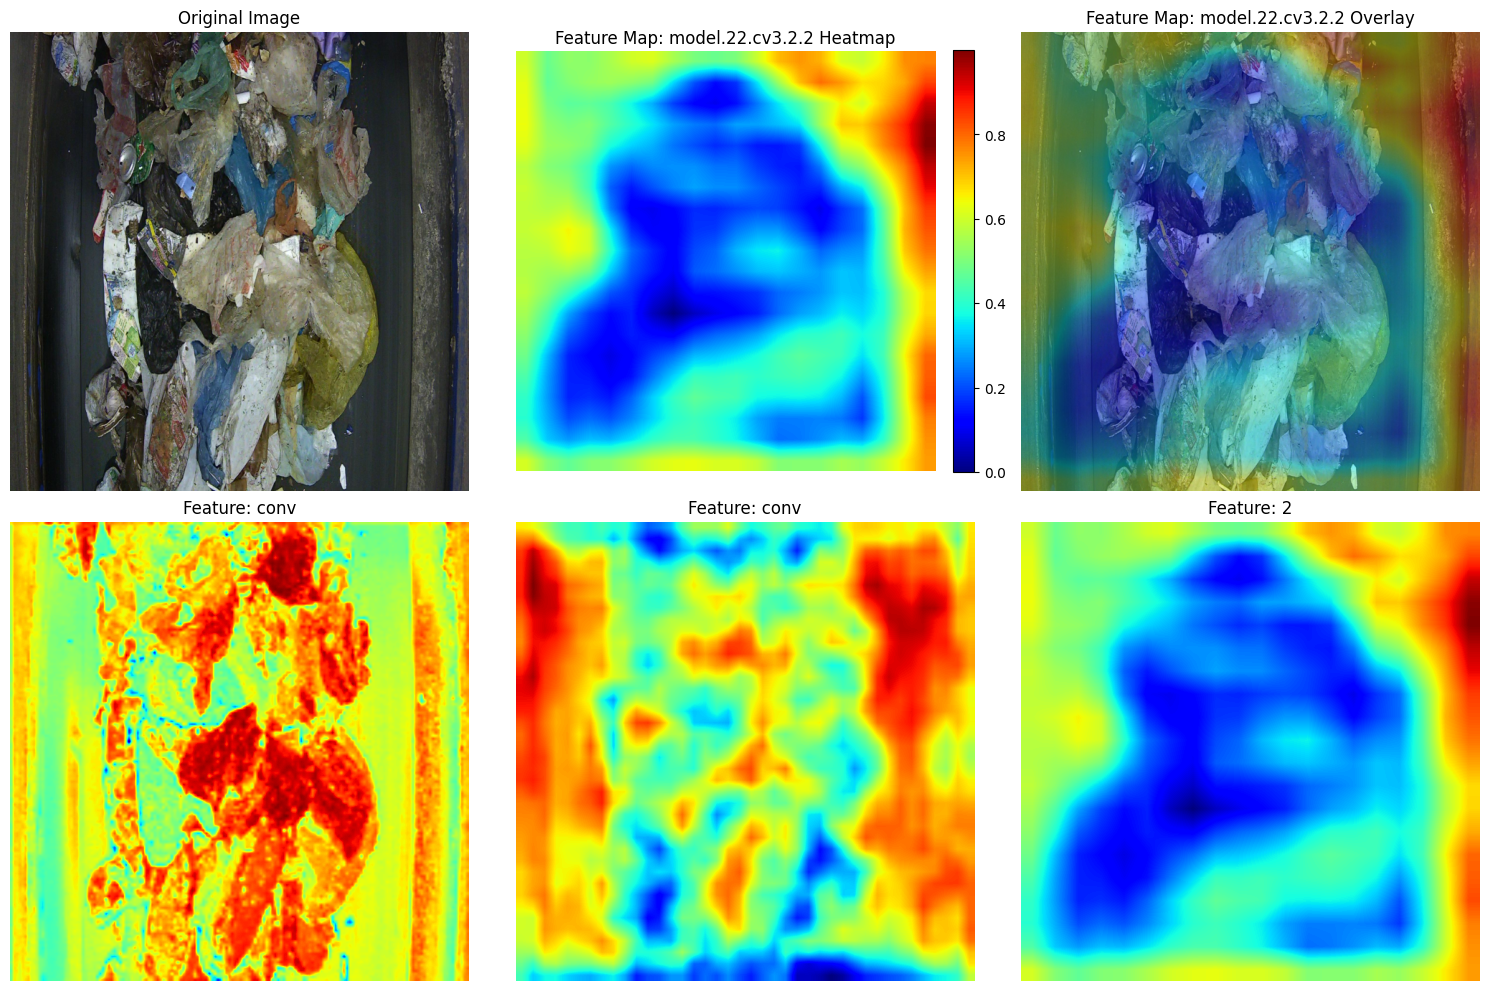


ANALYSIS COMPLETE
Final visualization method: Feature Map: model.22.cv3.2.2
Activation range: 0.0000 to 1.0000
High activation pixels (>0.7): 34321
Medium activation pixels (>0.5): 126554
✓ Good activation regions detected!


In [6]:
import torch
import torch.nn.functional as F
from ultralytics import YOLOWorld
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image

class RTDETRGradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = {}
        self.gradients = {}
        self.hooks = []
        
    def register_hooks(self):
        """Register hooks on multiple layers to capture features"""
        def get_activation(name):
            def hook(model, input, output):
                self.feature_maps[name] = output.detach()
            return hook
        
        def get_gradient(name):
            def hook(model, input, output):
                def backward_hook(grad):
                    self.gradients[name] = grad.detach()
                if output.requires_grad:
                    handle = output.register_hook(backward_hook)
                    self.hooks.append(handle)
            return hook
        
        # Register hooks on backbone layers
        layers_to_hook = []
        for name, module in self.model.named_modules():
            if any(x in name for x in ['backbone', 'neck']) and 'conv' in str(type(module)).lower():
                layers_to_hook.append((name, module))
        
        # Select a few key layers
        if len(layers_to_hook) > 5:
            selected_layers = [
                layers_to_hook[2],   # Early feature
                layers_to_hook[len(layers_to_hook)//2],  # Mid feature
                layers_to_hook[-3],  # High-level feature
            ]
        else:
            selected_layers = layers_to_hook
        
        print("Registering hooks on layers:")
        for name, module in selected_layers:
            print(f"  {name}")
            hook1 = module.register_forward_hook(get_activation(name))
            hook2 = module.register_forward_hook(get_gradient(name))
            self.hooks.extend([hook1, hook2])
        
        return [name for name, _ in selected_layers]
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def generate_cam(self, input_tensor, target_layer_name=None):
        """Generate CAM for the given input"""
        # Clear previous data
        self.feature_maps = {}
        self.gradients = {}
        
        # Forward pass
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        
        # Get model predictions
        with torch.enable_grad():
            outputs = self.model(input_tensor)
            
            # Create a meaningful target based on predictions
            if isinstance(outputs, (list, tuple)):
                output = outputs[0]
            else:
                output = outputs
            
            # For RT-DETR, create target from highest confidence predictions
            if hasattr(output, 'shape') and len(output.shape) >= 2:
                if output.shape[-1] > 4:  # Has class predictions
                    # Get confidence scores (assuming last N-4 elements are class scores)
                    conf_scores = output[..., 4:]
                    target_score = conf_scores.max()
                else:
                    target_score = output.abs().max()
            else:
                target_score = output.abs().sum()
            
            print(f"Target score: {target_score}")
            
            # Backward pass
            target_score.backward(retain_graph=True)
        
        # Generate CAM from the best available layer
        best_cam = None
        best_score = 0
        
        for layer_name in self.feature_maps.keys():
            if layer_name in self.gradients:
                try:
                    feature_map = self.feature_maps[layer_name]
                    gradient = self.gradients[layer_name]
                    
                    # Compute weights (global average pooling of gradients)
                    if len(gradient.shape) == 4:  # [batch, channels, height, width]
                        weights = torch.mean(gradient, dim=[2, 3], keepdim=True)
                        
                        # Weighted combination of feature maps
                        cam = torch.sum(weights * feature_map, dim=1, keepdim=True)
                        
                        # Apply ReLU and normalize
                        cam = F.relu(cam)
                        
                        # Check quality of CAM
                        cam_np = cam.squeeze().cpu().numpy()
                        cam_var = np.var(cam_np)
                        
                        print(f"Layer {layer_name}: CAM variance = {cam_var:.6f}")
                        
                        if cam_var > best_score:
                            best_cam = cam_np
                            best_score = cam_var
                            print(f"  -> New best CAM from {layer_name}")
                            
                except Exception as e:
                    print(f"Error processing layer {layer_name}: {e}")
        
        return best_cam, best_score

# Alternative approach using feature visualization
def visualize_feature_maps(model, input_tensor, layer_name=None):
    """Visualize raw feature maps from the model"""
    feature_maps = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook
    
    hooks = []
    
    # Register hooks on convolutional layers
    conv_layers = []
    for name, module in model.named_modules():
        if 'conv' in str(type(module)).lower() and hasattr(module, 'weight'):
            conv_layers.append((name, module))
    
    # Select some representative layers
    if len(conv_layers) > 3:
        selected = [conv_layers[1], conv_layers[len(conv_layers)//2], conv_layers[-2]]
    else:
        selected = conv_layers
    
    for name, module in selected:
        hook = module.register_forward_hook(hook_fn(name))
        hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return feature_maps

# Main execution
print("Starting RT-DETR Grad-CAM Analysis...")

# Step 1: Load model
model = YOLOWorld("/kaggle/input/yolov8x_worldv2/pytorch/default/1/yolov8x_worldv2_28.pt")
model.eval()

# Step 2: Load and preprocess image
# img_path = "/kaggle/input/corrrected-test-data/test/images/Seldom_img_21-Apr_18-21-06_jpg.rf.96aab53a95d876199ac22b0828ff72cd.jpg"
img_path="/kaggle/input/corrrected-test-data/test/images/Monitoring_photo_2_test_25-Mar_12-13-05_jpg.rf.a5a93bb9cbc96dba9e4b31540b3804c8.jpg"
try:
    orig_img = Image.open(img_path).convert("RGB")
    print(f"Loaded image: {orig_img.size}")
except FileNotFoundError:
    print(f"Image not found, creating test image")
    orig_img = Image.new('RGB', (640, 640), color=(100, 150, 100))

# Step 3: Transform image
transform = Compose([
    Resize((640, 640)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(orig_img).unsqueeze(0)

# Step 4: Try Grad-CAM approach
print("\n" + "="*50)
print("ATTEMPTING GRAD-CAM")
print("="*50)

grad_cam = RTDETRGradCAM(model.model)
available_layers = grad_cam.register_hooks()

try:
    cam_result, cam_score = grad_cam.generate_cam(input_tensor)
    
    if cam_result is not None and cam_score > 1e-6:
        print(f"✓ Grad-CAM successful! Score: {cam_score:.6f}")
        
        # Process CAM
        cam_resized = cv2.resize(cam_result, (640, 640))
        cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
        
        gradcam_success = True
    else:
        print("✗ Grad-CAM failed - low quality result")
        gradcam_success = False
        
except Exception as e:
    print(f"✗ Grad-CAM failed: {e}")
    gradcam_success = False

finally:
    grad_cam.remove_hooks()

# Step 5: Feature map visualization as backup
print("\n" + "="*50)
print("FEATURE MAP VISUALIZATION")
print("="*50)

feature_maps = visualize_feature_maps(model.model, input_tensor)

# Process feature maps
processed_features = {}
for layer_name, fmap in feature_maps.items():
    if len(fmap.shape) == 4:  # [batch, channels, height, width]
        # Average across channels
        avg_fmap = torch.mean(fmap[0], dim=0).cpu().numpy()
        
        # Resize to image size
        fmap_resized = cv2.resize(avg_fmap, (640, 640))
        
        # Normalize
        fmap_norm = (fmap_resized - fmap_resized.min()) / (fmap_resized.max() - fmap_resized.min() + 1e-8)
        
        processed_features[layer_name] = fmap_norm
        print(f"Processed feature map from {layer_name}: {fmap_norm.min():.3f} to {fmap_norm.max():.3f}")

# Step 6: Visualization
img_np = np.array(orig_img.resize((640, 640)))

# Choose the best visualization
if gradcam_success:
    print(f"\nUsing Grad-CAM result (score: {cam_score:.6f})")
    final_cam = cam_normalized
    viz_title = "Grad-CAM"
elif processed_features:
    print(f"\nUsing feature map visualization")
    # Use the feature map with highest variance
    best_feature = max(processed_features.items(), key=lambda x: np.var(x[1]))
    final_cam = best_feature[1]
    viz_title = f"Feature Map: {best_feature[0]}"
else:
    print("\nNo good visualization available, creating synthetic example")
    final_cam = np.random.rand(640, 640)
    viz_title = "Fallback"

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Main results
axes[0, 0].imshow(img_np)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

im1 = axes[0, 1].imshow(final_cam, cmap='jet')
axes[0, 1].set_title(f"{viz_title} Heatmap")
axes[0, 1].axis("off")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Create overlay
heatmap = cv2.applyColorMap(np.uint8(255 * final_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

axes[0, 2].imshow(overlay)
axes[0, 2].set_title(f"{viz_title} Overlay")
axes[0, 2].axis("off")

# Row 2: Feature map comparisons (if available)
if len(processed_features) >= 3:
    feature_items = list(processed_features.items())[:3]
    for i, (name, fmap) in enumerate(feature_items):
        im = axes[1, i].imshow(fmap, cmap='jet')
        axes[1, i].set_title(f"Feature: {name.split('.')[-1]}")
        axes[1, i].axis("off")
else:
    # Show detection results
    try:
        results = model(orig_img)
        if results and len(results) > 0:
            result = results[0]
            if result.boxes is not None:
                # Create detection visualization
                det_img = img_np.copy()
                boxes = result.boxes.xyxy.cpu().numpy()
                confs = result.boxes.conf.cpu().numpy()
                
                for box, conf in zip(boxes, confs):
                    x1, y1, x2, y2 = box.astype(int)
                    cv2.rectangle(det_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(det_img, f'{conf:.2f}', (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                axes[1, 0].imshow(det_img)
                axes[1, 0].set_title("Model Detections")
                axes[1, 0].axis("off")
                
                print(f"\nModel detected {len(boxes)} objects:")
                for i, (box, conf) in enumerate(zip(boxes, confs)):
                    print(f"  Object {i+1}: confidence {conf:.3f}")
        
        # Fill remaining subplots
        for i in range(1, 3):
            axes[1, i].text(0.5, 0.5, 'Additional\nAnalysis', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].axis("off")
            
    except Exception as e:
        print(f"Error showing detections: {e}")
        for i in range(3):
            axes[1, i].axis("off")

plt.tight_layout()
plt.show()

print(f"\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print(f"Final visualization method: {viz_title}")
print(f"Activation range: {final_cam.min():.4f} to {final_cam.max():.4f}")
print(f"High activation pixels (>0.7): {np.sum(final_cam > 0.7)}")
print(f"Medium activation pixels (>0.5): {np.sum(final_cam > 0.5)}")

if np.sum(final_cam > 0.7) > 100:
    print("✓ Good activation regions detected!")
else:
    print("⚠ Low activation - may need different approach or layer selection")